In [89]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Instantiate a BigQuery client
client = bigquery.Client(project='dh-logistics-product-ops')
bq_storage = bigquery_storage.BigQueryReadClient()

g:\My Drive\APAC\Autopricing\Switchback Testing\switchback_test_dag\venv_sb\lib\site-packages\google\auth\_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Downloading: 100%|██████████| 19/19 [00:02<00:00,  8.83rows/s]


In [5]:
# Define the global inputs
entity_id = "FP_TH"
test_keyword = "%price sensitivity1"
analysis_start_date = "2023-03-15"

In [6]:
# Extract the test setups 
tests_query = """
    SELECT *
    FROM `dh-logistics-product-ops.pricing.pricing_elasticity_tests_summary`
    WHERE entity_id = "{entity_id_var}" AND test_name LIKE "{test_keyword_var}"
""".format(entity_id_var=entity_id, test_keyword_var=test_keyword)

# Execute the query
df_test = client.query(tests_query).result().to_dataframe(bqstorage_client=bq_storage, progress_bar_type="tqdm")

Downloading: 100%|██████████| 19/19 [00:02<00:00,  8.25rows/s]


In [9]:
# Extract order data of these tests
orders_query = """
    WITH test_query AS (
    SELECT DISTINCT test_name
    FROM `dh-logistics-product-ops.pricing.pricing_elasticity_tests_summary`
    WHERE entity_id = "{entity_id_var}" AND test_name LIKE "{test_keyword_var}"
    )

    SELECT 
        -- Identifiers and supplementary fields     
        -- Date and time
        a.created_date AS created_date_utc,

        -- Location of order
        a.region,
        a.entity_id,
        a.country_code,
        a.city_name,
        a.city_id,
        a.zone_name,
        a.zone_id,

        -- Order/customer identifiers and session data
        a.variant,
        a.experiment_id AS test_id,
        b.test_name,
        a.platform_order_code,
        a.scheme_id,
        a.vendor_price_scheme_type,	-- The assignment type of the scheme to the vendor during the time of the order, such as "Automatic", "Manual", "Campaign", and "Country Fallback".
        
        -- Vendor data and information on the delivery
        a.vendor_id,
        b.target_group AS target_group_bi,
        a.is_in_treatment,
        a.chain_id,
        a.chain_name,
        a.vertical_type,
        a.delivery_status,
        a.is_own_delivery,
        a.exchange_rate,

        -- Business KPIs (These are the components of profit)
        a.dps_delivery_fee_local,
        a.dps_travel_time_fee_local,
        a.dps_surge_fee_local,
        a.delivery_fee_local,
        IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local) AS delivery_fee_local_incl_disc_and_vouchers,
        CASE WHEN ent.region != "MENA" THEN a.commission_local ELSE COALESCE(mn.commission_amount_lc, a.commission_local) END AS commission_local,
        a.joker_vendor_fee_local,
        COALESCE(a.service_fee_local, 0) AS service_fee_local,
        a.mov_customer_fee_local AS sof_local,
        a.delivery_costs_local,
        CASE
            WHEN ent.region IN ("Europe", "Asia") THEN COALESCE( -- Get the delivery fee data of Pandora countries from Pandata tables
                pd.delivery_fee_local, 
                -- In 99 pct of cases, we won"t need to use that fallback logic as pd.delivery_fee_local is reliable
                IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local)
            )
            -- If the order comes from a non-Pandora country, use delivery_fee_local
            WHEN ent.region NOT IN ("Europe", "Asia") THEN (CASE WHEN a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE THEN 0 ELSE a.delivery_fee_local END)
        END AS actual_df_paid_by_customer,
        a.gfv_local,
        a.gmv_local
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` a
    LEFT JOIN `fulfillment-dwh-production.cl.dps_ab_test_orders_v2` b ON a.entity_id = b.entity_id AND a.order_id = b.order_id
    LEFT JOIN `fulfillment-dwh-production.pandata_curated.pd_orders` pd -- Contains info on the orders in Pandora countries
    ON TRUE 
        AND a.entity_id = pd.global_entity_id
        AND a.platform_order_code = pd.code 
        AND a.created_date = pd.created_date_utc -- There is no country_code field in this table
    LEFT JOIN `tlb-data-prod.data_platform.fct_billing` mn ON a.platform_order_code = CAST(mn.order_id AS STRING) AND a.entity_id IN ("TB_OM", "TB_IQ", "TB_AE", "TB_KW", "YS_TR", "TB_QA", "TB_JO", "HF_EG", "HS_SA", "TB_BH")
    INNER JOIN `dh-logistics-product-ops.pricing.entities_lb_rollout_tests` ent ON a.entity_id = ent.entity_id -- Get the region associated with every entity_id
    WHERE TRUE
        AND a.created_date >= DATE("{analysis_start_date_var}")
        AND b.test_name IN (SELECT * FROM test_query) -- Search for relevant tests
        AND a.is_sent -- Successful orders
        AND a.is_own_delivery -- OD orders only
        AND a.variant != "Original" -- Exclude orders from ASAs
        AND is_match_experiment_vertical -- Filter for sessions where the parent vertical of the vendor matches the parent vertical of the experiment	
    ;
""".format(entity_id_var=entity_id, test_keyword_var=test_keyword, analysis_start_date_var=analysis_start_date)

# Execute the orders query
df_orders = client.query(orders_query).result().to_dataframe(bqstorage_client=bq_storage, progress_bar_type="tqdm")

Downloading: 100%|██████████| 2586549/2586549 [00:46<00:00, 55493.98rows/s]


In [107]:
# Calculate the average DF per variant

# First, filter out orders from ASA
df_orders = df_orders[df_orders["variant"] != "Original"]

# Pick the list of functions for each KPI
list_agg_functions = ["mean", "nunique"]
agg_function_selection = {"delivery_fee_local": "mean", "dps_travel_time_fee_local": "mean", "platform_order_code": "nunique"}

# Perform the aggregation
df_agg_metrics = df_orders.\
    groupby(["entity_id", "test_name", "variant"])[["delivery_fee_local", "dps_travel_time_fee_local", "platform_order_code"]].\
    agg(agg_function_selection).\
    rename({"platform_order_code": "order_count"}, axis=1).\
    reset_index()

# Create a new data frame showing the values for the control group
df_control = df_orders[df_orders["variant"] == "Control"].\
    groupby(["entity_id", "test_name"])[["delivery_fee_local", "dps_travel_time_fee_local", "platform_order_code"]].\
    agg(agg_function_selection).\
    rename({"platform_order_code": "order_count"}, axis=1).\
    reset_index()

# Join df_agg_metrics with df_control
df_agg_metrics = pd.merge(left=df_agg_metrics, right=df_control, on=["entity_id", "test_name"], how="left", suffixes=["", "_control"])

# # Add new columns showing the elasticity calculations
df_agg_metrics = df_agg_metrics.assign(
    pct_diff_orders=round(df_agg_metrics["order_count"]/df_agg_metrics["order_count_control"] - 1, 4),
    pct_diff_tt_fee=round(df_agg_metrics["dps_travel_time_fee_local"]/df_agg_metrics["dps_travel_time_fee_local_control"] - 1, 4),
    pct_diff_df=round(df_agg_metrics["delivery_fee_local"]/df_agg_metrics["delivery_fee_local_control"] - 1, 4),
    elasticity=round((df_agg_metrics["order_count"]/df_agg_metrics["order_count_control"] - 1) / (df_agg_metrics["dps_travel_time_fee_local"]/df_agg_metrics["dps_travel_time_fee_local_control"] - 1), 4)
)

# Display the final data frame
df_agg_metrics

,entity_id,test_name,variant,delivery_fee_local,dps_travel_time_fee_local,order_count,delivery_fee_local_control,dps_travel_time_fee_local_control,order_count_control,pct_diff_orders,pct_diff_tt_fee,pct_diff_df,elasticity
0,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Control,4.960839,5.118105,25689,4.960839,5.118105,25689,0.0000,0.0000,0.0000,NaN
1,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Variation1,8.497639,8.782527,25410,4.960839,5.118105,25689,-0.0109,0.7160,0.7129,-0.0152
2,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Variation2,6.420925,6.656265,26791,4.960839,5.118105,25689,0.0429,0.3005,0.2943,0.1427
3,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Variation3,4.093211,4.173934,28827,4.960839,5.118105,25689,0.1222,-0.1845,-0.1749,-0.6622
4,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Variation4,4.407472,4.517456,25722,4.960839,5.118105,25689,0.0013,-0.1174,-0.1115,-0.0109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,FP_TH,TH_20230313_Yasothon_price sensitivity1,Control,10.552322,10.747622,1787,10.552322,10.747622,1787,0.0000,0.0000,0.0000,NaN
91,FP_TH,TH_20230313_Yasothon_price sensitivity1,Variation1,12.788706,12.872462,1576,10.552322,10.747622,1787,-0.1181,0.1977,0.2119,-0.5972
92,FP_TH,TH_20230313_Yasothon_price sensitivity1,Variation2,11.293266,11.606042,1589,10.552322,10.747622,1787,-0.1108,0.0799,0.0702,-1.3872
93,FP_TH,TH_20230313_Yasothon_price sensitivity1,Variation3,8.339777,8.203281,1707,10.552322,10.747622,1787,-0.0448,-0.2367,-0.2097,0.1891


In [85]:
# Extract sessions data of these tests
sessions_query = """
  WITH test_query AS (
    SELECT DISTINCT test_name
    FROM `dh-logistics-product-ops.pricing.pricing_elasticity_tests_summary`
    WHERE entity_id = "{entity_id_var}" AND test_name LIKE "{test_keyword_var}"
  )
  SELECT
    entity_id,
    created_date,
    created_at,
    test_name,
    ga_session_id,
    variant,
    test_zone_id AS zone_id,
    perseus_client_id,
    vendor_code,
    target_group,
    treatment,
    shop_list_no,
    shop_menu_no,
    checkout_no,
    transaction_no,
  FROM `fulfillment-dwh-production.cl.dps_cvr_ab_tests_treatment`
  WHERE TRUE
    AND created_date >= "{analysis_start_date_var}"
    AND test_name IN (SELECT * FROM test_query) -- Search for relevant tests
    AND vertical_parent_in_test = TRUE -- Filter for sessions where the parent vertical of the vendor matches the parent vertical of the experiment
    AND variant != "Original" -- Filter out sessions with variant = "Original"
""".format(entity_id_var=entity_id, test_keyword_var=test_keyword, analysis_start_date_var=analysis_start_date)

# Execute the sessions query
df_sessions = client.query(sessions_query).result().to_dataframe(bqstorage_client=bq_storage, progress_bar_type="tqdm")

Downloading: 100%|██████████| 20356000/20356000 [06:13<00:00, 54541.95rows/s]


In [108]:
def count_unique_non_null(x):
    return x.nunique(dropna=True)

# Perform the aggregation
df_agg_cvr = df_sessions.\
    groupby(["entity_id", "test_name", "variant"])[["ga_session_id", "shop_list_no", "shop_menu_no", "checkout_no", "transaction_no"]].\
    agg(count_unique_non_null).\
    reset_index()

# Add new columns calculating CVR
df_agg_cvr["cvr"] = round(df_agg_cvr["transaction_no"] / df_agg_cvr["ga_session_id"], 4)

# Create a new data frame showing the values for the control group
df_agg_cvr = pd.merge(
    left=df_agg_cvr,
    right=df_agg_cvr[df_agg_cvr["variant"] == "Control"][["entity_id", "test_name", "cvr"]],
    on=["entity_id", "test_name"],
    how="left",
    suffixes=["", "_control"]
)

# Calculate the CVR % difference between variation and control
df_agg_cvr = df_agg_cvr.assign(
    pct_diff_cvr=round(df_agg_cvr["cvr"] / df_agg_cvr["cvr_control"] - 1, 4),
)
df_agg_cvr

,entity_id,test_name,variant,ga_session_id,shop_list_no,shop_menu_no,checkout_no,transaction_no,cvr,cvr_control,pct_diff_cvr
0,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Control,45438,26242,42524,23099,21602,0.4754,0.4754,0.0000
1,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Variation1,46562,26264,43467,22850,21355,0.4586,0.4754,-0.0353
2,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Variation2,46930,26610,43834,24152,22563,0.4808,0.4754,0.0114
3,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Variation3,49244,27546,46193,25991,24414,0.4958,0.4754,0.0429
4,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Variation4,45937,25928,42916,22950,21386,0.4656,0.4754,-0.0206
...,...,...,...,...,...,...,...,...,...,...,...
90,FP_TH,TH_20230313_Yasothon_price sensitivity1,Control,3979,1940,3618,1753,1611,0.4049,0.4049,0.0000
91,FP_TH,TH_20230313_Yasothon_price sensitivity1,Variation1,3673,1730,3303,1626,1505,0.4097,0.4049,0.0119
92,FP_TH,TH_20230313_Yasothon_price sensitivity1,Variation2,3833,1962,3452,1577,1431,0.3733,0.4049,-0.0780
93,FP_TH,TH_20230313_Yasothon_price sensitivity1,Variation3,3825,1945,3439,1675,1520,0.3974,0.4049,-0.0185


In [109]:
# Join df_agg_cvr to df_agg_metrics
df_agg_metrics = pd.merge(left=df_agg_metrics, right=df_agg_cvr[["entity_id", "test_name", "variant", "cvr", "pct_diff_cvr"]], on=["entity_id", "test_name", "variant"], how='left')
df_agg_metrics

,entity_id,test_name,variant,delivery_fee_local,dps_travel_time_fee_local,order_count,delivery_fee_local_control,dps_travel_time_fee_local_control,order_count_control,pct_diff_orders,pct_diff_tt_fee,pct_diff_df,elasticity,cvr,pct_diff_cvr
0,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Control,4.960839,5.118105,25689,4.960839,5.118105,25689,0.0000,0.0000,0.0000,NaN,0.4754,0.0000
1,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Variation1,8.497639,8.782527,25410,4.960839,5.118105,25689,-0.0109,0.7160,0.7129,-0.0152,0.4586,-0.0353
2,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Variation2,6.420925,6.656265,26791,4.960839,5.118105,25689,0.0429,0.3005,0.2943,0.1427,0.4808,0.0114
3,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Variation3,4.093211,4.173934,28827,4.960839,5.118105,25689,0.1222,-0.1845,-0.1749,-0.6622,0.4958,0.0429
4,FP_TH,TH_20230313_Khon Kaen_price sensitivity1,Variation4,4.407472,4.517456,25722,4.960839,5.118105,25689,0.0013,-0.1174,-0.1115,-0.0109,0.4656,-0.0206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,FP_TH,TH_20230313_Yasothon_price sensitivity1,Control,10.552322,10.747622,1787,10.552322,10.747622,1787,0.0000,0.0000,0.0000,NaN,0.4049,0.0000
91,FP_TH,TH_20230313_Yasothon_price sensitivity1,Variation1,12.788706,12.872462,1576,10.552322,10.747622,1787,-0.1181,0.1977,0.2119,-0.5972,0.4097,0.0119
92,FP_TH,TH_20230313_Yasothon_price sensitivity1,Variation2,11.293266,11.606042,1589,10.552322,10.747622,1787,-0.1108,0.0799,0.0702,-1.3872,0.3733,-0.0780
93,FP_TH,TH_20230313_Yasothon_price sensitivity1,Variation3,8.339777,8.203281,1707,10.552322,10.747622,1787,-0.0448,-0.2367,-0.2097,0.1891,0.3974,-0.0185


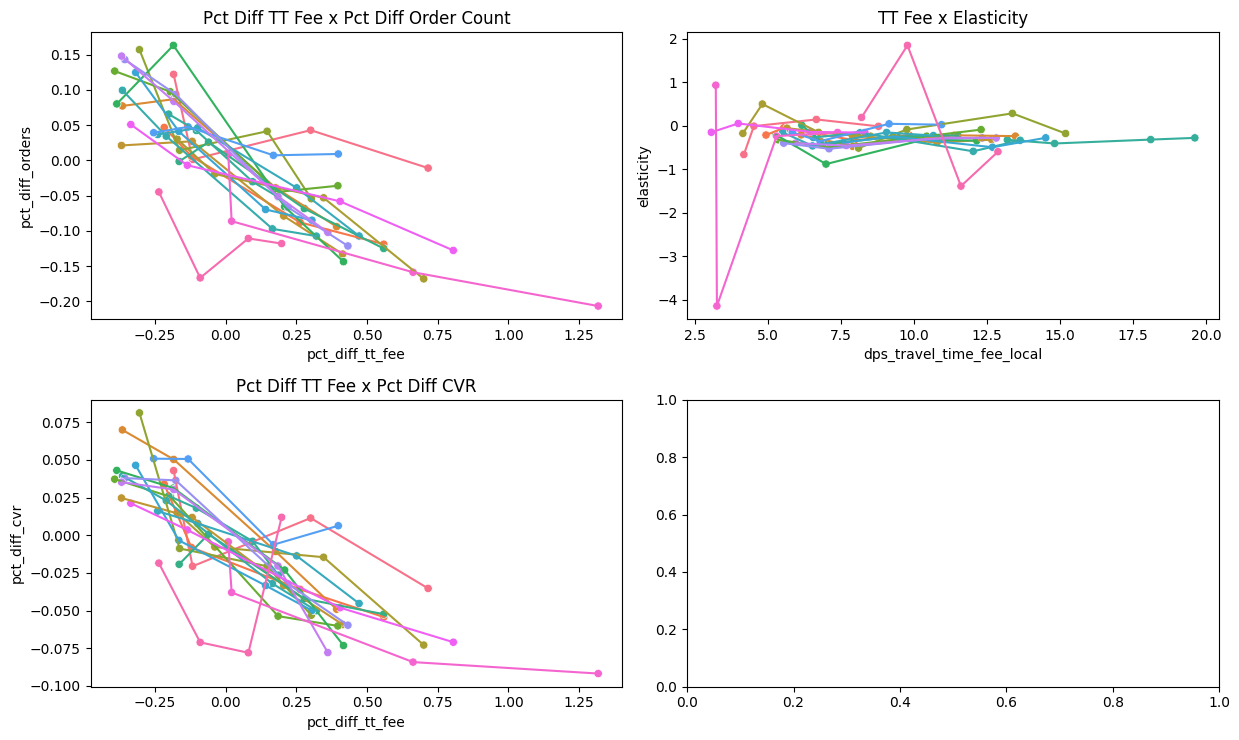

In [116]:
# Create the data frame for plotting
df_plot = df_agg_metrics[df_agg_metrics["variant"] != "Control"]\
    [["entity_id", "test_name", "variant", "pct_diff_tt_fee", "pct_diff_orders", "pct_diff_cvr", "elasticity", "dps_travel_time_fee_local", "order_count", "cvr"]]

# Create some EDA plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12.5, 7.5))

# 1st chart: pct_diff_tt_fee x pct_diff_orders
sns.scatterplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_orders", hue="test_name", ax=axes[0,0])
sns.lineplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_orders", hue="test_name", ax=axes[0,0])
axes[0,0].set_title("Pct Diff TT Fee x Pct Diff Order Count")

# 2nd chart: TT fee x elasticity
sns.scatterplot(data=df_plot, x="dps_travel_time_fee_local", y="elasticity", hue="test_name", ax=axes[0,1])
sns.lineplot(data=df_plot, x="dps_travel_time_fee_local", y="elasticity", hue="test_name", ax=axes[0,1])
axes[0,1].set_title("TT Fee x Elasticity")

# 3rd chart: TT fee x CVR
sns.scatterplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_cvr", hue="test_name", ax=axes[1,0])
sns.lineplot(data=df_plot, x="pct_diff_tt_fee", y="pct_diff_cvr", hue="test_name", ax=axes[1,0])
axes[1,0].set_title("Pct Diff TT Fee x Pct Diff CVR")

# Remove the legends
axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
axes[1,0].get_legend().remove()

# Right layout
plt.tight_layout()